**In this experiment, I aim to understand the impact of noise levels on the reliability of gene transcription data, using SNR (Signal-to-Noise Ratio) as the indicator. The goal is to identify an SNR threshold above which the data can be considered reliable.**

In [2]:
import os
os.chdir('./synthetic_gene')
%pwd

'C:\\Users\\user\\Desktop\\burstInfer1\\synthetic_gene'

### Generate Promoter State

In [3]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(6626285)

# Define transition probability matrix
transition_probabilities = np.array([
       [0.8549579 , 0.1450421 ],
       [0.20215972, 0.79784028]
])

number_of_traces = 200  # Number of Markov chains
length_of_each_trace = 250  # Length of each Markov chain

# Initialize matrix to store all Markov chains
chain_matrix = np.ones((number_of_traces, length_of_each_trace))

# Generate Markov chains
for j in range(number_of_traces):
    starting_value = 0  # Initial state (indexing starts from 0 in Python)
    chain_length = length_of_each_trace
    chain = np.zeros(chain_length)
    chain[0] = starting_value
    for i in range(1, chain_length):
        this_step_distribution = transition_probabilities[int(chain[i - 1])]
        cumulative_distribution = np.cumsum(this_step_distribution)
        r = np.random.rand()
        chain[i] = np.where(cumulative_distribution > r)[0][0]
    chain_matrix[j, :] = chain

# Save the results to a CSV file
output_path = 'gene_w5.csv'
pd.DataFrame(chain_matrix).to_csv(output_path, header=False, index=False)

print(f"Data saved to {output_path}")


Data saved to gene_w5.csv


Figure 2. (A) Synthetic Promoter Sequence Trace Over Time.


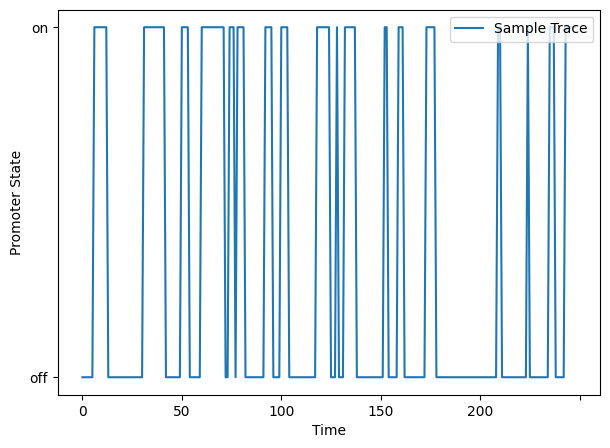

In [4]:
##### Figure 2. Fluorescence Time Series and Inferred Promoter Trace. (A) Synthetic Promoter Sequence Trace Over Time.
import pandas as pd
import matplotlib.pyplot as plt

def plot_traces_separately(input_file, num_traces=10):
    """
    Plot each trace in separate figures from the input CSV file.
    
    Parameters:
    input_file (str): Path to the input CSV file with fluorescent traces.
    num_traces (int): Number of traces to plot (default is 10).
    """
    # Load the fluorescent traces with specified column names
    num_time_points = 250  # Adjust this based on the number of time points in your data
    column_names = ['Trace'] + [f'{i}' for i in range(num_time_points)]
    traces_df = pd.read_csv(input_file, header=None, names=column_names)
    
    # Plot each trace in separate figures
    for i in range(num_traces):
        plt.figure(figsize=(7, 5))
        plt.plot(traces_df.iloc[i, 1:], label=f'Sample Trace')  # Skip the first column 'Trace'
#         plt.title(f'Promoter State of Sample Trace')
        plt.xlabel('Time')
        plt.ylabel('Promoter State')
        plt.legend(loc='upper right')
        plt.xticks(ticks=range(0, num_time_points+1, 50))
        plt.yticks(ticks=[0, 1], labels=['off', 'on'])  # Set y-axis labels to 'off' and 'on'
        plt.show()

print("Figure 2. (A) Synthetic Promoter Sequence Trace Over Time.")
input_file = 'gene_w5.csv'
plot_traces_separately(input_file, num_traces=1)

### Generate Traces 

In [5]:
# Revise create_synthetic_fluorescent_traces_w5.py to modify noise level
##### Generate traces (Without adding noise)

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd
from burstInfer.get_adjusted import get_adjusted  
from burstInfer.ms2_loading_coeff import ms2_loading_coeff 

def generate_fluorescent_traces(noise_level, input_file, output_file):
    # Set random seed
    seed_setter = 633463
    np.random.seed(seed_setter)
    np.seterr(divide='ignore')

    # Import data
    signal_holder = genfromtxt(input_file, delimiter=',')

    # Initialize parameters
    K = 2
    n_traces = len(signal_holder)
    W = 5
    mu = np.array([[150], [8000]])
    noise = noise_level

    t_MS2 = 30
    deltaT = 20
    kappa = t_MS2 / deltaT

    # Compute MS2 coefficients
    ms2_coeff = ms2_loading_coeff(kappa, W)
    ms2_coeff_flipped = np.flip(ms2_coeff, 1)
    count_reduction_manual = np.zeros((1, W-1))
    for t in range(W-1):
        count_reduction_manual[0, t] = np.sum(ms2_coeff[0, t+1:])
    count_reduction_manual = np.reshape(count_reduction_manual, (W-1, 1))

    mask = np.int32((2**W)-1)

    # Determine the length of the traces from the first row of signal_holder
    length = len(signal_holder[0])
    fluorescence_holder = np.zeros((n_traces, length))

    for i in range(n_traces):
        single_promoter = signal_holder[i, :]
        single_trace = np.zeros(length)
        
        window_storage = int(single_promoter[0])
        single_trace[0] = ((get_adjusted(window_storage, K, W, ms2_coeff)[0] * mu[1, 0]) + 
                           (get_adjusted(window_storage, K, W, ms2_coeff)[1] * mu[0, 0])) + np.random.normal(0, noise)
        
        present_state_list = [int(single_promoter[0])]
        
        for t in range(1, length):
            present_state = int(single_promoter[t])
            window_storage = np.bitwise_and((present_state_list[t-1] << 1) + present_state, mask)
            present_state_list.append(window_storage)
            single_trace[t] = ((get_adjusted(window_storage, K, W, ms2_coeff)[0] * mu[1, 0]) + 
                               (get_adjusted(window_storage, K, W, ms2_coeff)[1] * mu[0, 0])) + np.random.normal(0, noise)
            
        fluorescence_holder[i, :] = single_trace

    # Encapsulate data into a DataFrame and return
    sampling_dataframe = pd.DataFrame(fluorescence_holder)
    sampling_dataframe.to_csv(output_file, index=False)
    return sampling_dataframe

# Parameters
noise_level = 0
input_file = 'gene_w5.csv'
output_file = 'gene_w5_fluorescent_traces.csv'

# Generate traces
traces = generate_fluorescent_traces(noise_level, input_file, output_file)
print("Generate fluorescent traces finish!")


14:58:53.731440
start program
Generate fluorescent traces finish!


In [6]:
traces

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,637.5,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,3254.166667,10450.000000,18300.000000,...,24187.500000,16337.500000,8487.500000,637.500000,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,34000.000000
1,637.5,637.500000,637.500000,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,34000.000000,34000.000000,...,637.500000,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,34000.000000,34000.000000,31383.333333,24187.500000
2,637.5,637.500000,637.500000,637.500000,637.500000,3254.166667,10450.000000,15683.333333,16337.500000,16337.500000,...,8487.500000,8487.500000,3254.166667,10450.000000,18300.000000,23533.333333,24187.500000,16337.500000,8487.500000,3254.166667
3,637.5,3254.166667,10450.000000,15683.333333,18954.166667,26150.000000,26150.000000,26150.000000,34000.000000,34000.000000,...,637.500000,637.500000,637.500000,3254.166667,10450.000000,15683.333333,16337.500000,16337.500000,11104.166667,10450.000000
4,637.5,637.500000,3254.166667,7833.333333,11104.166667,18300.000000,26150.000000,26150.000000,34000.000000,34000.000000,...,31383.333333,24187.500000,16337.500000,11104.166667,10450.000000,18300.000000,26150.000000,34000.000000,34000.000000,34000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,637.5,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,...,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,3254.166667,10450.000000
196,637.5,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,3254.166667,7833.333333,...,26150.000000,26150.000000,26150.000000,34000.000000,34000.000000,34000.000000,34000.000000,34000.000000,31383.333333,24187.500000
197,637.5,637.500000,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,34000.000000,34000.000000,34000.000000,...,637.500000,637.500000,637.500000,637.500000,637.500000,3254.166667,7833.333333,11104.166667,18300.000000,26150.000000
198,637.5,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,31383.333333,24187.500000,16337.500000,8487.500000,...,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000


Figure 2(B): Generated Synthetic MS2 Fluorescence Intensity Trace


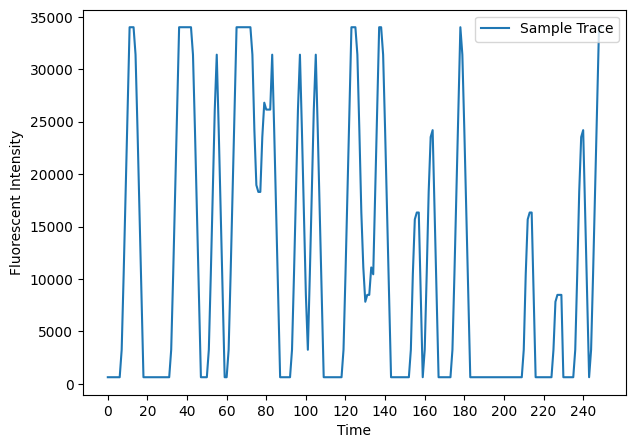

In [7]:
##### Plot the first trace

import pandas as pd
import matplotlib.pyplot as plt

def plot_traces_separately(input_file, num_traces=10):
    """
    Plot each trace in separate figures from the input CSV file.
    
    Parameters:
    input_file (str): Path to the input CSV file with fluorescent traces.
    num_traces (int): Number of traces to plot (default is 10).
    """
    # Load the fluorescent traces
    traces_df = pd.read_csv(input_file)
    
    # Plot each trace in separate figures
    for i in range(num_traces):
        plt.figure(figsize=(7, 5))
        plt.plot(traces_df.iloc[i], label=f'Sample Trace')
#         plt.title(f'Fluorescent Trace {i}')
        plt.xlabel('Time')
        plt.ylabel('Fluorescent Intensity')
        plt.legend()
#         plt.grid(True)
        plt.xticks(ticks=range(0, len(traces_df.columns)+1, 20))
        plt.show()

print("Figure 2(B): Generated Synthetic MS2 Fluorescence Intensity Trace")
input_file = 'gene_w5_fluorescent_traces.csv'
plot_traces_separately(input_file, num_traces=1)


In [8]:
import numpy as np
import pandas as pd

def generate_noisy_traces(input_file, output_file, snr_db_range, snr_step=5):
    """
    Generate noisy traces with different SNR levels and save to CSV.
    
    Parameters:
    input_file (str): Path to the input CSV file with noise level 0 data.
    output_file (str): Path to the output CSV file to save generated traces.
    snr_db_range (tuple): Range of SNR values in dB (default is (0, 40)).
    snr_step (int): Step size for SNR values in dB (default is 10).
    """
    # Set random seed for reproducibility
    np.random.seed(633463)
    
    # Load the input data, skip the first column (index)
    signal_data = pd.read_csv(input_file).values

    # Calculate signal power (including mean)
    signal_power = np.mean(signal_data ** 2, axis=1) + np.mean(signal_data, axis=1) ** 2

    # Prepare a list to store results
    results = []

    # Generate noisy traces with different SNR levels
    for snr_db in range(snr_db_range[0], snr_db_range[1] + 1, snr_step):
        for i in range(signal_data.shape[0]):
            signal = signal_data[i, :]
            noise_power = signal_power[i] / (10 ** (snr_db / 10))
            noise_std = np.sqrt(noise_power)
            noise = np.random.normal(0, noise_std, signal.shape)
            noisy_signal = signal + noise
            results.append([i, snr_db] + list(noisy_signal))

    # Add the original signal with SNR_dB = inf
    for i in range(signal_data.shape[0]):
        signal = signal_data[i, :]
        results.append([i, np.inf] + list(signal))
    
    # Create a DataFrame from the results and save to CSV
    columns = ['Trace', 'SNR_dB'] + [f'Time_{t}' for t in range(signal_data.shape[1])]
    results_df = pd.DataFrame(results, columns=columns)
    results_df.to_csv(output_file, index=False)
    return results_df

# Example usage
input_file = 'gene_w5_fluorescent_traces.csv'
output_file = 'noisy_fluorescent_traces_with_snr.csv'
traces = generate_noisy_traces(input_file, output_file, snr_db_range=(0, 60))
print("Generated noisy fluorescent traces with different SNR levels finished!")


Generated noisy fluorescent traces with different SNR levels finished!


In [9]:
traces

,Trace,SNR_dB,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,...,Time_240,Time_241,Time_242,Time_243,Time_244,Time_245,Time_246,Time_247,Time_248,Time_249
0,0,0.0,-17012.738478,36698.336270,22345.295004,32012.263170,18319.100415,-8851.129315,4509.111078,-28707.597582,...,37531.334694,-12364.513609,27110.020751,-30020.078344,9652.569757,12017.779075,57665.686128,35852.356148,21773.982960,34589.559636
1,1,0.0,15832.390788,-9395.717424,5816.971972,-8720.320643,-18694.237833,-1166.533989,6961.198845,48737.008802,...,-28771.564428,-928.687742,-5482.037765,18421.823948,59192.516059,40170.353728,55465.558861,11963.881809,-962.451365,-15684.216409
2,2,0.0,8944.073882,-28339.912325,-32581.797755,19964.457186,10976.161521,11937.823511,29623.314063,24915.593197,...,13512.893315,22003.892684,3344.179037,27194.788118,6517.901054,11550.875483,28343.588890,15750.520829,21578.493919,418.622405
3,3,0.0,1180.096322,8702.227045,14268.085241,14579.361855,4925.947859,53023.844035,37616.001746,24863.647678,...,9826.559928,8846.864945,3165.920459,15034.689148,15838.519538,-9242.796644,-47885.980351,12768.389334,5707.333854,-10132.745502
4,4,0.0,-21106.527750,7093.524670,-12826.349197,27863.476458,68990.724660,33711.400896,28486.324886,4877.311787,...,80250.246015,39959.026057,59577.805561,9843.280338,8954.552089,7243.025048,32096.993888,43824.203012,45424.201005,40264.259522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,195,inf,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,...,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,3254.166667,10450.000000
2796,196,inf,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,...,26150.000000,26150.000000,26150.000000,34000.000000,34000.000000,34000.000000,34000.000000,34000.000000,31383.333333,24187.500000
2797,197,inf,637.500000,637.500000,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,34000.000000,...,637.500000,637.500000,637.500000,637.500000,637.500000,3254.166667,7833.333333,11104.166667,18300.000000,26150.000000
2798,198,inf,637.500000,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,31383.333333,24187.500000,...,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000


Figure 3: Effect of Noise Levels on Synthetic Fluorescence Intensity Traces


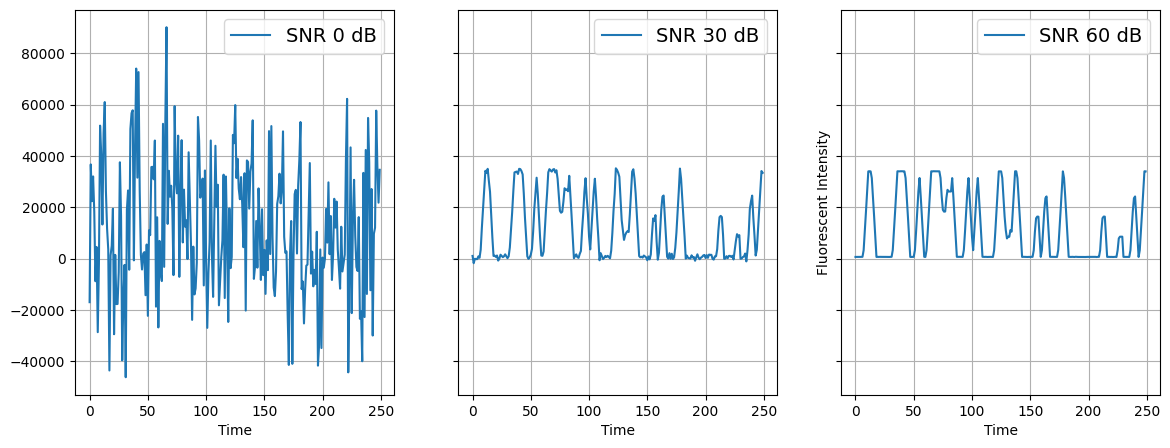

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_selected_traces_by_snr(input_file, num_traces=10):
    """
    Plot traces with SNR levels 0, 30, and 60 dB in a single row, and a separate figure for ground truth from the input CSV file.
    
    Parameters:
    input_file (str): Path to the input CSV file with noisy traces and SNR levels.
    num_traces (int): Number of traces to plot (default is 10).
    """
    # Load the noisy traces with SNR levels
    traces_df = pd.read_csv(input_file)

    # Get unique trace IDs
    unique_traces = traces_df['Trace'].unique()[:num_traces]
    
    snr_levels = [0, 30, 60]

    for trace in unique_traces:
        fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
        
        trace_data = traces_df[traces_df['Trace'] == trace]
        
        for ax, snr_dB in zip(axes, snr_levels):
            snr_data = trace_data[trace_data['SNR_dB'] == snr_dB]
            time_points = [col for col in snr_data.columns if col.startswith('Time_')]
            ax.plot(range(len(time_points)), snr_data[time_points].values.flatten(), label=f'SNR {snr_dB} dB')
#             ax.set_title(f'Sample Trace at SNR {snr_dB} dB')
            ax.set_xlabel('Time')
            ax.grid(True)
            ax.legend(fontsize=14)

#         plt.suptitle(f'Sample Trace with Different SNR Levels')
        plt.ylabel('Fluorescent Intensity')
#         plt.xticks(ticks=range(0, len(time_points)+1, 10))
        
        plt.show()

print("Figure 3: Effect of Noise Levels on Synthetic Fluorescence Intensity Traces")
input_file = 'noisy_fluorescent_traces_with_snr.csv'
plot_selected_traces_by_snr(input_file, num_traces=1)


 As illustrated in Figures 3, the fluorescence intensity traces show how increasing levels of noise affect the signal.

### Compute Autocorrelation for traces

In [11]:
import numpy as np
import pandas as pd

def compute_autocorrelation(signal, max_lag):
    """
    Compute autocorrelation for a given signal.
    
    Parameters:
    signal (numpy array): Input signal.
    max_lag (int): Maximum lag value for autocorrelation.
    
    Returns:
    list: Autocorrelation values for the given signal.
    """
    n = len(signal)
    mean_signal = np.mean(signal)
    var_signal = np.var(signal)
    
    autocorr = [1.0]  # lag 0 autocorrelation is always 1
    
    for lag in range(1, max_lag + 1):
        if lag < n:
            cov = np.sum((signal[:n - lag] - mean_signal) * (signal[lag:] - mean_signal)) / n
            autocorr.append(cov / var_signal)
        else:
            autocorr.append(np.nan)  # Not enough data to compute autocorrelation for this lag
    
    return autocorr

def compute_autocorrelation_for_traces(traces):
    """
    Compute autocorrelation for each trace and each SNR level.
    
    Parameters:
    traces (DataFrame): Input data containing traces and SNR levels.
    max_lag (int): Maximum lag value for autocorrelation.
    
    Returns:
    DataFrame: DataFrame containing autocorrelation values for each trace and SNR level.
    """
    max_lag = len(traces.iloc[0])-2
    results = []

    # Iterate over each trace and each SNR level
    for (trace, snr), group in traces.groupby(['Trace', 'SNR_dB']):
        signal = group.iloc[:, 2:].values.flatten()  # Select signal data ignoring Trace and SNR_dB columns
        autocorr = compute_autocorrelation(signal, max_lag)
        results.append([trace, snr] + autocorr)
    
    # Create DataFrame with the results
    columns = ['Trace', 'SNR_dB'] + [f'Lag_{lag}' for lag in range(max_lag + 1)]
    autocorr_df = pd.DataFrame(results, columns=columns)
    
    return autocorr_df

# Load the input data
input_file = 'noisy_fluorescent_traces_with_snr.csv'
traces = pd.read_csv(input_file)

# Compute autocorrelation for each trace and each SNR level
autocorr_df = compute_autocorrelation_for_traces(traces)

# Save the results to a new CSV file
output_file = 'autocorrelation_results.csv'
autocorr_df.to_csv(output_file, index=False)
print("Autocorrelation computation finished!")


Autocorrelation computation finished!


In [12]:
autocorr_df

,Trace,SNR_dB,Lag_0,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,...,Lag_241,Lag_242,Lag_243,Lag_244,Lag_245,Lag_246,Lag_247,Lag_248,Lag_249,Lag_250
0,0,0.0,1.0,0.223469,0.187819,0.144083,-0.027813,-0.041485,-0.117234,0.030828,...,-0.007747,-0.016744,0.011539,0.003851,0.010714,-0.001052,-0.001307,0.001721,-0.004072,NaN
1,0,5.0,1.0,0.455144,0.380262,0.282352,0.087525,0.028001,0.021123,-0.010045,...,-0.003966,-0.006174,-0.007356,-0.007350,-0.010786,-0.016289,-0.011887,-0.009987,-0.005818,NaN
2,0,10.0,1.0,0.709071,0.594574,0.399215,0.288701,0.134587,0.057707,0.050849,...,-0.002938,-0.002546,-0.007508,-0.009968,-0.010252,-0.016946,-0.013587,-0.012828,-0.007823,NaN
3,0,15.0,1.0,0.846512,0.675607,0.453430,0.260427,0.111846,0.027538,-0.024553,...,-0.009022,-0.014069,-0.016021,-0.016398,-0.013832,-0.013073,-0.011565,-0.008985,-0.006536,NaN
4,0,20.0,1.0,0.889746,0.699941,0.467799,0.250559,0.099077,0.016244,-0.026338,...,-0.009078,-0.012478,-0.013839,-0.014954,-0.016486,-0.017577,-0.015968,-0.010648,-0.007234,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,199,45.0,1.0,0.934017,0.784620,0.596359,0.410157,0.263773,0.166679,0.105601,...,0.013898,0.019636,0.022524,0.023745,0.022300,0.018545,0.013971,0.009351,0.004685,NaN
2796,199,50.0,1.0,0.934200,0.785107,0.596909,0.411144,0.265012,0.167979,0.106679,...,0.014011,0.019688,0.022575,0.023718,0.022317,0.018523,0.013953,0.009306,0.004628,NaN
2797,199,55.0,1.0,0.934249,0.785070,0.596756,0.410921,0.264929,0.168076,0.107090,...,0.013995,0.019621,0.022476,0.023600,0.022170,0.018407,0.013809,0.009187,0.004573,NaN
2798,199,60.0,1.0,0.934217,0.785000,0.596661,0.410667,0.264547,0.167660,0.106642,...,0.014039,0.019666,0.022541,0.023685,0.022286,0.018517,0.013892,0.009259,0.004632,NaN


### Dwell Time

Figure 4. Mean Autocorrelation by Lag and SNR Level Using Direct Measurement of Dwell Time.


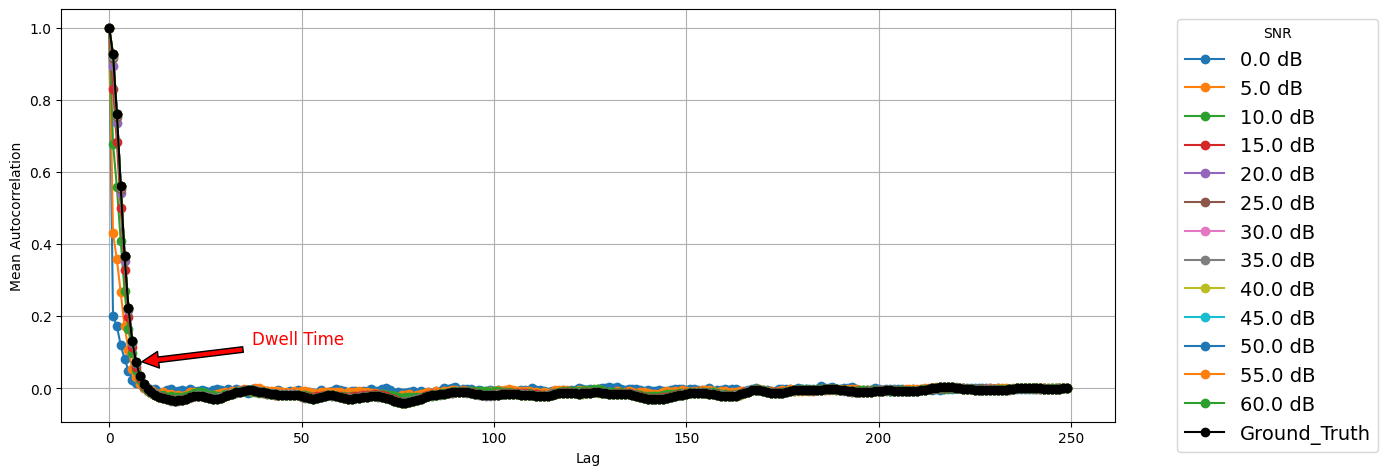

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_mean_autocorrelation_by_snr(input_file):
    """
    Plot mean autocorrelation results for each SNR level.
    
    Parameters:
    input_file (str): Path to the input CSV file with autocorrelation results.
    """
    # Load the autocorrelation results
    autocorr_df = pd.read_csv(input_file)

    # Replace inf in SNR_dB with 'Ground_Truth'
    autocorr_df['SNR_dB'] = autocorr_df['SNR_dB'].replace(float('inf'), 'Ground_Truth')

    # Get unique SNR levels and sort them, making sure 'Ground_Truth' is treated as the highest value
    snr_levels = sorted(autocorr_df['SNR_dB'].unique(), key=lambda x: (x != 'Ground_Truth', x))

    plt.figure(figsize=(14,5))
    
    # Plot mean autocorrelation for each SNR level
    for snr_level in snr_levels:
        if snr_level == 'Ground_Truth':
            continue  # Skip Ground Truth for now

        # Filter data for the specified SNR level
        snr_data = autocorr_df[autocorr_df['SNR_dB'] == snr_level]

        # Compute mean autocorrelation values
        mean_autocorr = snr_data.iloc[:, 2:].mean()
        lags = [int(col.split('_')[1]) for col in snr_data.columns if col.startswith('Lag_')]

        plt.plot(lags, mean_autocorr, marker='o', linestyle='-', label=f'{snr_level} dB')

    # Plot Ground Truth last
    snr_data = autocorr_df[autocorr_df['SNR_dB'] == 'Ground_Truth']
    mean_autocorr = snr_data.iloc[:, 2:].mean()
    lags = [int(col.split('_')[1]) for col in snr_data.columns if col.startswith('Lag_')]
    plt.plot(lags, mean_autocorr, marker='o', linestyle='-', label='Ground_Truth', color='black')

    # Find the lag where the autocorrelation stabilizes
    # Assuming that stabilization is at the first significant drop, e.g., below 0.1
    stabilization_lag = next(lag for lag, value in enumerate(mean_autocorr) if value < 0.1)

    # Add arrow indicating dwell time
    plt.annotate(
        'Dwell Time',
        xy=(stabilization_lag, mean_autocorr[stabilization_lag]),
        xytext=(stabilization_lag + 30, mean_autocorr[stabilization_lag] + 0.05),
        arrowprops=dict(facecolor='red', shrink=0.05),
        fontsize=12,
        color='red'
    )

#     plt.title('Mean Autocorrelation by Lag and SNR Level with Indicated Dwell Time')
    plt.xlabel('Lag')
    plt.ylabel('Mean Autocorrelation')
    plt.legend(title='SNR', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Figure 4. Mean Autocorrelation by Lag and SNR Level Using Direct Measurement of Dwell Time.")
input_file = 'autocorrelation_results.csv'
plot_mean_autocorrelation_by_snr(input_file)


As shown in the figure 4, the "Dwell Time" represents a critical point where the autocorrelation function stabilizes. This characteristic time scale serves as a useful indicator of the system's dynamics.

### Use Autocorrelation to find Dwell time

To accurately determine the dwell time for each curve, we use a fitting function (`calculate_dwell_time_method1`) to fit the autocorrelation data to the `autocorrelation_function_method1`. This function models the autocorrelation as a function of time lag (`tau`), using parameters `c` and `T` to describe the decay. The script then calculates the mean and standard deviation of the autocorrelation across multiple traces and plots the results, including the fitted curve to visually represent the estimated dwell time (`T`).

Figure 5. Mean Autocorrelation by Lag and SNR Level Using Direct Measurement of Dwell Time.


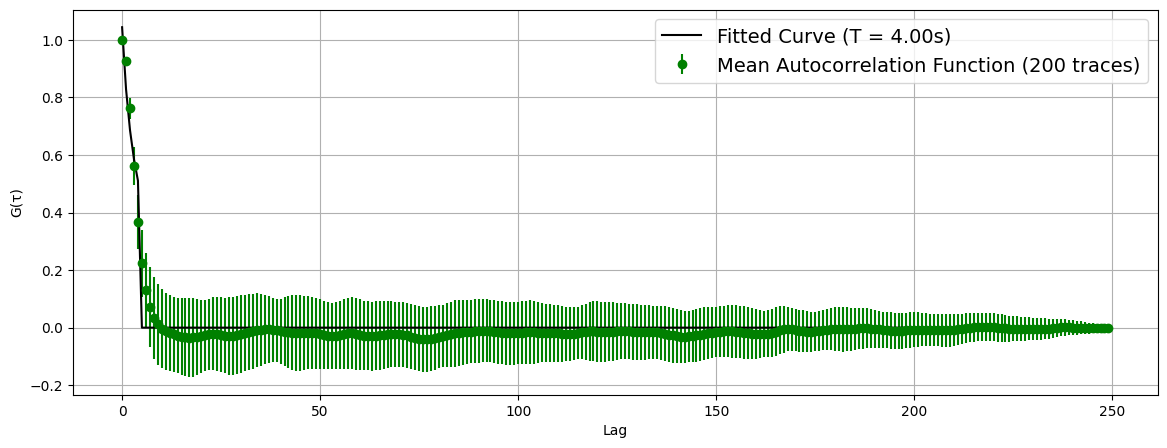

In [14]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def heaviside(x):
    return np.where(x >= 0, 1.0, 0.0)

def autocorrelation_function_method1(tau, c, T):
    return (c * T / (1 + c * tau)) * heaviside(T - tau)

def calculate_dwell_time_method1(tau_values, G_values):
    initial_guess = [1.0, 100.0]  # Initial guesses for fitting parameters c and T
    params, _ = curve_fit(autocorrelation_function_method1, tau_values, G_values, p0=initial_guess)
    c, T = params  # Extract the fitted parameters
    return c, T

def plot_autocorrelation_with_error_and_fit(tau_values, G_mean, G_std, c, T):
    plt.figure(figsize=(14, 5))
    
    # Plot the mean autocorrelation function with error bars
    plt.errorbar(tau_values, G_mean, yerr=G_std, fmt='o', color='green', label='Mean Autocorrelation Function (200 traces)')
    
    # Calculate and plot the fitted curve
    G_fit_values = autocorrelation_function_method1(tau_values, c, T)
    plt.plot(tau_values, G_fit_values, '-', color='black', label=f'Fitted Curve (T = {T:.2f}s)')
    
    plt.xlabel('Lag')
    plt.ylabel('G(τ)')
#     plt.title('Autocorrelation Function with Dwell Time (n=200)')
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

# Load the autocorrelation results from CSV file
input_autocorr_file = 'autocorrelation_results.csv'
autocorr_df = pd.read_csv(input_autocorr_file)

# Select all rows where SNR_dB == inf (indicating ground truth data)
all_rows = autocorr_df[autocorr_df["SNR_dB"] == float('inf')]

# Calculate the mean and standard deviation of the autocorrelation functions across all selected rows
G_values_all = all_rows.iloc[:, 2:-1].values
G_mean = np.mean(G_values_all, axis=0)
G_std = np.std(G_values_all, axis=0)
tau_values = np.arange(len(G_mean))

# Calculate dwell time using method 1
c, T = calculate_dwell_time_method1(tau_values, G_mean)

print("Figure 5. Mean Autocorrelation by Lag and SNR Level Using Direct Measurement of Dwell Time.")
# Plot the autocorrelation function with error bars and the fitted curve, including T in the legend
plot_autocorrelation_with_error_and_fit(tau_values, G_mean, G_std, c, T)


Figure 5 demonstrates how the parameter T, shown in the legend, effectively captures the point where the autocorrelation stabilizes. The close fit between the black curve and the green data points visually confirms the model's accuracy in describing the data.

Figure 6.  Autocorrelation Function under Different SNR Levels


D:\anaconda\envs\envs_notebook\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


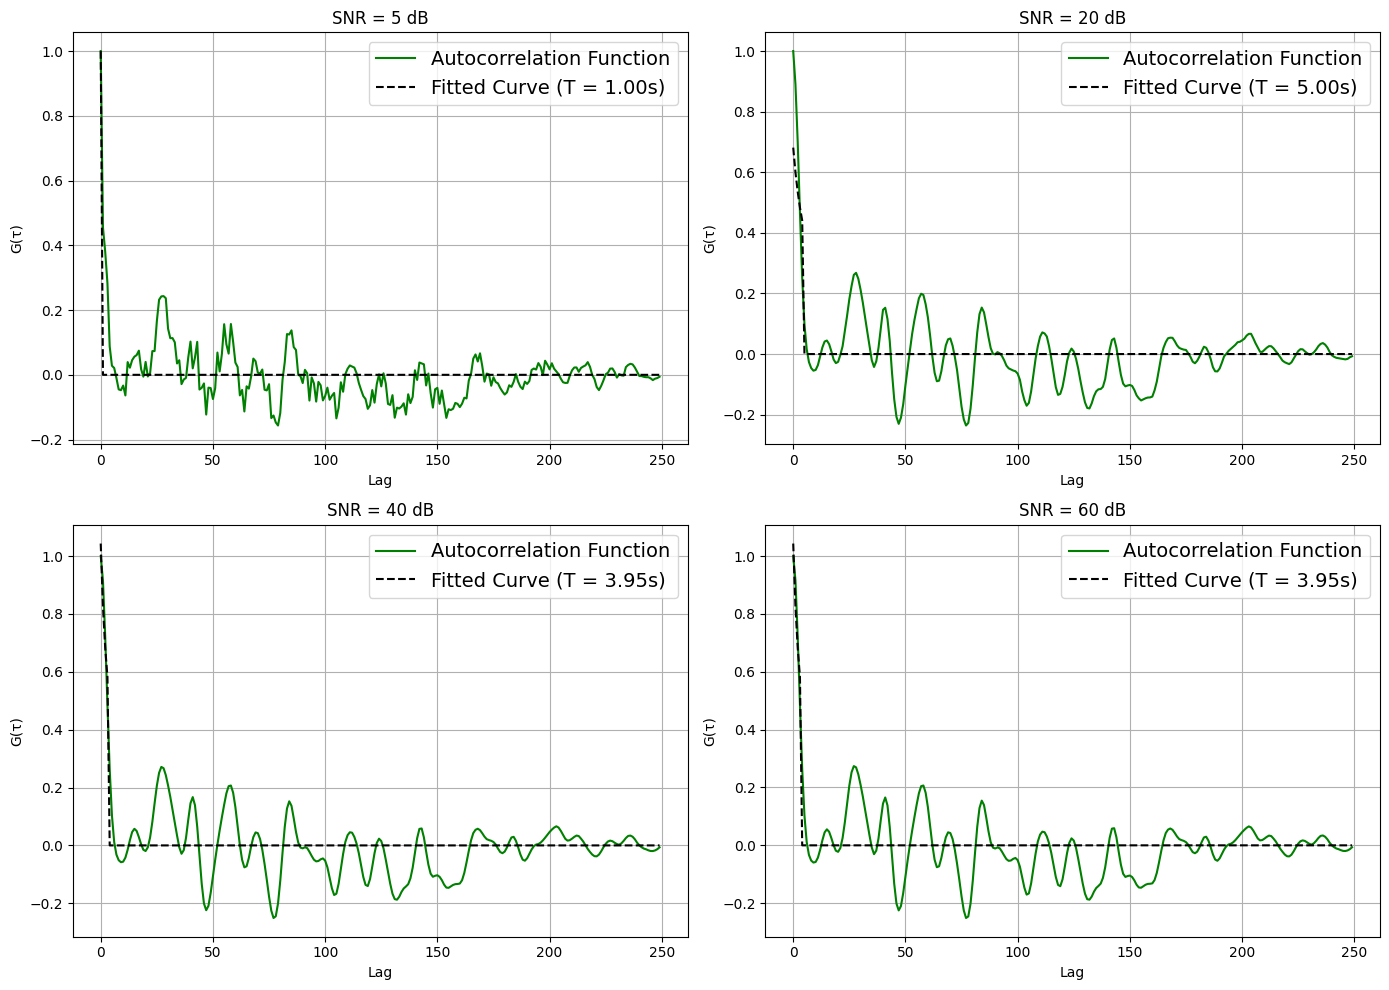

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def heaviside(x):
    return np.where(x >= 0, 1.0, 0.0)

def autocorrelation_function_method1(tau, c, T):
    return (c * T / (1 + c * tau)) * heaviside(T - tau)

def calculate_dwell_time_method1(tau_values, G_values):
    initial_guess = [1.0, 100.0]  # Initial guesses for fitting parameters c and T
    params, _ = curve_fit(autocorrelation_function_method1, tau_values, G_values, p0=initial_guess)
    c, T = params  # Extract the fitted parameters
    return c, T

def plot_autocorrelation_with_fit(ax, tau_values, G_values, c, T, title):
    # Plot the autocorrelation function
    ax.plot(tau_values, G_values, '-', color='green', label='Autocorrelation Function')
    
    # Calculate and plot the fitted curve
    G_fit_values = autocorrelation_function_method1(tau_values, c, T)
    ax.plot(tau_values, G_fit_values, '--', color='black', label=f'Fitted Curve (T = {T:.2f}s)')
    
    ax.set_xlabel('Lag')
    ax.set_ylabel('G(τ)')
    ax.set_title(title)
    ax.legend(fontsize=14)
    ax.grid(True)
    
print("Figure 6.  Autocorrelation Function under Different SNR Levels")
# Load the autocorrelation results from CSV file
input_autocorr_file = 'autocorrelation_results.csv'
autocorr_df = pd.read_csv(input_autocorr_file)

# Define the SNR values to be plotted
snr_values = [5, 20, 40, 60]

# Create subplots for each SNR value
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

for i, snr in enumerate(snr_values):
    row = autocorr_df[autocorr_df["SNR_dB"] == snr].iloc[0]
    
    # Extract G values and tau values for the current SNR
    G_values = row.iloc[2:-1].values
    tau_values = np.arange(len(G_values))
    
    # Calculate dwell time for the current SNR
    c, T = calculate_dwell_time_method1(tau_values, G_values)
    
    # Plot autocorrelation function with fitted curve
    plot_autocorrelation_with_fit(axs[i // 2, i % 2], tau_values, G_values, c, T, f'SNR = {snr} dB')

# Adjust layout
plt.tight_layout()
plt.show()


Figures 6  illustrate how the Signal-to-Noise Ratio (SNR) impacts the dwell time. In the low SNR condition (5 dB), where noise level is high, the autocorrelation function exhibits significant fluctuations, and the dwell time deviates noticeably from that in higher SNR conditions. In contrast, at higher SNR levels (40 dB and 60 dB), the curves stabilize, and the dwell time consistently converges around 4 seconds. This suggests that with lower noise (higher SNR), the dwell time becomes more reliable and falls within a narrower range.

### Dwell Time Distribution Across Different SNR Levels

D:\anaconda\envs\envs_notebook\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Figure 9.  Dwell Time Distribution Across Different SNR Levels


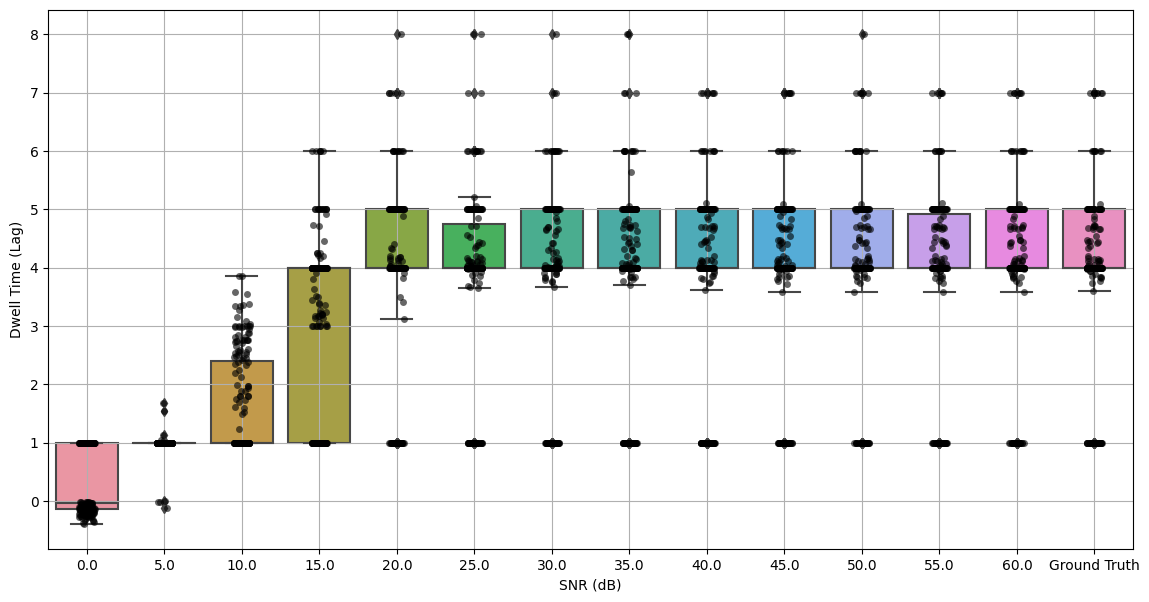

In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

def heaviside(x):
    return np.where(x >= 0, 1.0, 0.0)

def autocorrelation_function_method1(tau, c, T):
    return (c * T / (1 + c * tau)) * heaviside(T - tau)

def calculate_dwell_time_method1(tau_values, G_values):
    # Initial guesses for c and T
    initial_guess = [1.0, 100.0]

    # Fit the curve
    params, _ = curve_fit(autocorrelation_function_method1, tau_values, G_values, p0=initial_guess)
    
    # Extract fitted parameters
    c, T = params
    
    return c, T

# Load the autocorrelation results from CSV file
input_autocorr_file = 'autocorrelation_results.csv'
autocorr_df = pd.read_csv(input_autocorr_file)

# Initialize results list
results = []

for trace in range(len(autocorr_df)):
    trace_data = autocorr_df[autocorr_df["Trace"] == trace]
    for snr in trace_data["SNR_dB"].unique():
        snr_data = trace_data[trace_data["SNR_dB"] == snr]
        if not snr_data.empty:
            G_values = snr_data.iloc[0, 2:-1].values
            tau_values = np.arange(len(G_values))
            c, T = calculate_dwell_time_method1(tau_values, G_values)
            results.append({"Trace": trace, "SNR_dB": snr, "Dwell Time (T)": T})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("Figure 9.  Dwell Time Distribution Across Different SNR Levels")

# Box plot of dwell time vs. SNR_dB
plt.figure(figsize=(14, 7))
results_df['SNR_dB'] = results_df['SNR_dB'].replace(float('inf'), "Ground Truth")  # Replace inf with string for box plot

# Create the boxplot
sns.boxplot(x='SNR_dB', y='Dwell Time (T)', data=results_df)

# Overlay the stripplot (or swarmplot) to show individual data points
sns.stripplot(x='SNR_dB', y='Dwell Time (T)', data=results_df, color='black', alpha=0.6, jitter=True)  # Use 'jitter=True' to avoid overlapping points

# Alternatively, you could use swarmplot for a different style:
# sns.swarmplot(x='SNR_dB', y='Dwell Time (T)', data=results_df, color='red', alpha=0.6)

plt.xlabel('SNR (dB)')
plt.ylabel('Dwell Time (Lag)')
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
# plt.title('Box Plot of Dwell Time vs. SNR (dB) with Data Points')
plt.grid(True)
plt.show()


The experimental result show that SNR levels have a significant impact on dwell time distribution. At low SNR levels (e.g., 0 dB), the dwell times are highly variable and spread out, with many outliers, indicating that noise greatly affects the transcription process. As SNR increases (e.g., 5 dB, 10 dB), the distribution broadens, and the median dwell time rises, highlighting the influence of noise.

Once the SNR reaches 15 dB or higher, the dwell time distribution stabilizes, clustering between 4 and 6 time units with fewer outliers, indicating better data reliability. At SNR levels of 30 dB and above, the dwell time distribution closely matches the Ground Truth, suggesting that noise has been effectively minimized, making the data reliable for transcription analysis.

### Compare to the Ground Truth

In comparison with the Ground Truth, data at SNR levels of 30 dB and higher show minimal differences, indicating high reliability for transcription analysis. At these higher SNR levels, dwell times consistently fall within 4 to 5 time units, providing a benchmark for evaluating signal quality and data robustness for accurate analysis.